### Introduction: In this notebook we will be creating a timeseries model using lag function. We will be testing 2 models Random Forest and XGBoost and compare the performance for both of them.

In [ ]:
'''#Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pip install --upgrade pip
%pip uninstall pyodbc -y
%pip install -U pyodbc
%pip install xgboost
%pip install pandas==2.0.3
%pip install scikit-learn
%pip install "numpy<1.24"
%pip install==3.10.0
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error'''

#### Below are the various levels of dataframes created from the EDA notebook

In [101]:
df1=pd.read_csv('df1.csv') # has the filtered data for one facilityID

In [102]:
df2=pd.read_csv('eda_output.csv') # has data for Inyo National forest with one forcused parentID

In [103]:
df3=pd.read_csv('spike_nb.csv') # final timeseries dataframe from the last part of EDA for one facilityID

In [104]:
df3.head(2)

,Unnamed: 0,date,index,regioncode,facilityid,parentlocation,park,sitetype,productid,bookings,bookings_lag_1,bookings_lag_2,bookings_lag_3,bookings_lag_4
0,0,2023-07-07,175,R05,231956,Inyo National Forest,AGNEW MEADOWS GROUP CAMP,GROUP STANDARD NONELECTRIC,67022,3,NaN,NaN,NaN,NaN
1,1,2023-07-07,251,R05,231956,Inyo National Forest,AGNEW MEADOWS GROUP CAMP,GROUP STANDARD NONELECTRIC,67080,3,NaN,NaN,NaN,NaN


#### Plot a time series for a single facility ID 

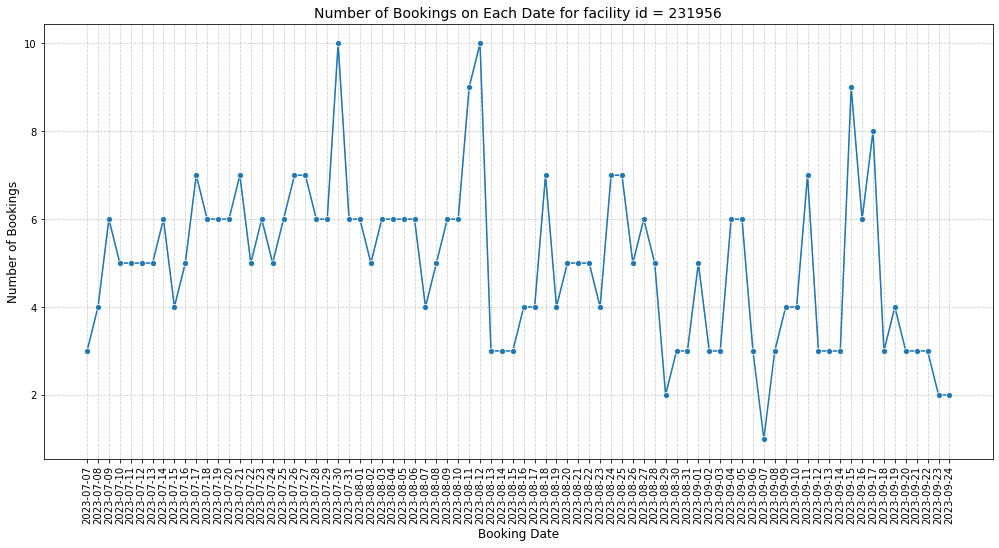

In [105]:
# Plotting
plt.figure(figsize=(17, 8))
sns.lineplot(data=df3, x='date', y='bookings', marker="o")

plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.title('Number of Bookings on Each Date for facility id = 231956', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)

#### Find the time resolution for our dataframe

In [106]:
# Example: Assume 'date' is your time series index
df3['date'] = pd.to_datetime(df3['date'])  # Ensure datetime format
df3 = df3.sort_values('date')  # Sort by time

# Compute differences between consecutive timestamps
time_diffs = df3['date'].diff().dropna()

# Find the most common time difference
resolution = time_diffs.mode()
print(f"Time Series Resolution: {resolution}")

Time Series Resolution: 0   0 days
Name: date, dtype: timedelta64[ns]


### In the next part of he notebook we will be working on creating lag features which we will be using as input to our model and then further train-test splitting the dataframe. After training 2 different models we will compare the performance and decide the next steps of adjusting the paramenters for improving the performance.
#### Model training steps
1. Verify if index exists
2. Verify if label exists
3. Add features
4. Feature engineering/feature normalization
5. Train-Test split
6. Train model
7. Evaluate
8. Repeat until you have a good model.


In [107]:
# deep clone using [:] so that existing object doesnt change
train_test_df = df3[:]
del train_test_df['Unnamed: 0']
print(train_test_df.columns)

label_column = 'bookings'
feature_columns = ['bookings_lag_1', 'bookings_lag_2', 'bookings_lag_3', 'bookings_lag_4']

Index(['date', 'index', 'regioncode', 'facilityid', 'parentlocation', 'park',
       'sitetype', 'productid', 'bookings', 'bookings_lag_1', 'bookings_lag_2',
       'bookings_lag_3', 'bookings_lag_4'],
      dtype='object')


In [108]:
train_test_df.head(2)

,date,index,regioncode,facilityid,parentlocation,park,sitetype,productid,bookings,bookings_lag_1,bookings_lag_2,bookings_lag_3,bookings_lag_4
0,2023-07-07,175,R05,231956,Inyo National Forest,AGNEW MEADOWS GROUP CAMP,GROUP STANDARD NONELECTRIC,67022,3,NaN,NaN,NaN,NaN
1,2023-07-07,251,R05,231956,Inyo National Forest,AGNEW MEADOWS GROUP CAMP,GROUP STANDARD NONELECTRIC,67080,3,NaN,NaN,NaN,NaN


#### Below are some functions to calculate lagged features, splitting the data and Linear Regression, Random Forest and XGBoost Models.

In [138]:
# Function to create Lagged features 
def create_lagged_features(df, target_col, lags=4, step=15):
    df_lagged = df.copy()
    for lag in range(1, lags+1):
        df_lagged[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df_lagged.dropna().reset_index(drop=True)

# Function to create Sequential split for training and testing of the time series df
def split_into_train_test(df, train_ratio):
        train_size = int(len(df) * train_ratio)

        # Sequential split
        train_df = df.iloc[:train_size]
        test_df = df.iloc[train_size:]

        print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
        print("Train Data Sample:\n", train_df.head(2))
        print("Train Data Sample:\n", test_df.head(2))
        return train_df, test_df

def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_random_forrest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    return model

def evalute_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Evaluate Model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Plot Actual vs Predictions
    df_plot = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_plot, x='Actual', y='Predicted', color='blue', alpha=0.6)
    sns.lineplot(x=[df_plot.min().min(), df_plot.max().max()], 
                y=[df_plot.min().min(), df_plot.max().max()], 
                color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()


In [139]:
df_lagged = create_lagged_features(train_test_df, target_col=label_column, lags=4, step=15)
train_df, test_df = split_into_train_test(df_lagged, train_ratio=0.7)# 70% train, 30% test
train_size = int(len(df_lagged) * train_ratio)

# Separate Features and Label (aka taget)
X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

Train size: (272, 17), Test size: (117, 17)
Train Data Sample:
         date  index regioncode  facilityid        parentlocation  \
0 2023-07-09    253        R05      231956  Inyo National Forest   
1 2023-07-09    388        R05      231956  Inyo National Forest   

                       park                    sitetype  productid  bookings  \
0  AGNEW MEADOWS GROUP CAMP  GROUP STANDARD NONELECTRIC      67080         6   
1  AGNEW MEADOWS GROUP CAMP  GROUP STANDARD NONELECTRIC      67080         6   

   bookings_lag_1  bookings_lag_2  bookings_lag_3  bookings_lag_4  \
0             6.0             6.0             4.0             4.0   
1             6.0             6.0             6.0             4.0   

   bookings_lag1  bookings_lag2  bookings_lag3  bookings_lag4  
0            4.0            4.0            4.0            4.0  
1            6.0            6.0            4.0            4.0  
Train Data Sample:
           date  index regioncode  facilityid        parentlocation  \


Linear Regression Model
MAE: 1.33
MSE: 3.23
RMSE: 1.80


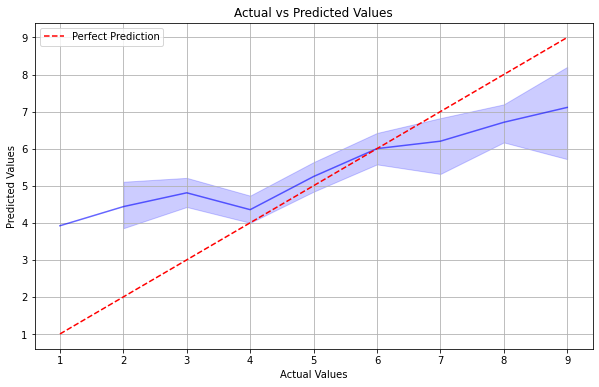

In [140]:
print('Linear Regression Model')
model = train_linear_regression(X_train, y_train)
evalute_model(model, X_test, y_test)

Random Forest Model
MAE: 1.31
MSE: 3.13
RMSE: 1.77


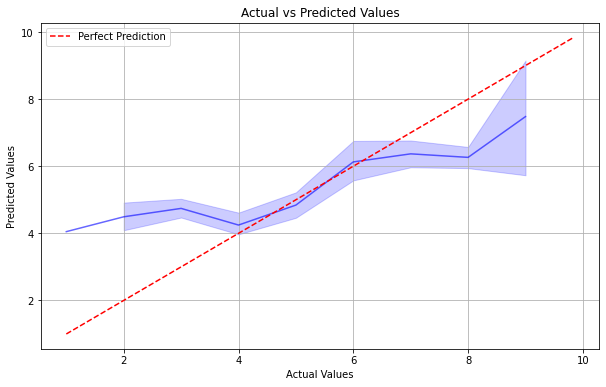

In [141]:
print('Random Forest Model')
model = train_random_forrest(X_train, y_train)
evalute_model(model, X_test, y_test)

XGBoost Model
MAE: 1.29
MSE: 3.06
RMSE: 1.75


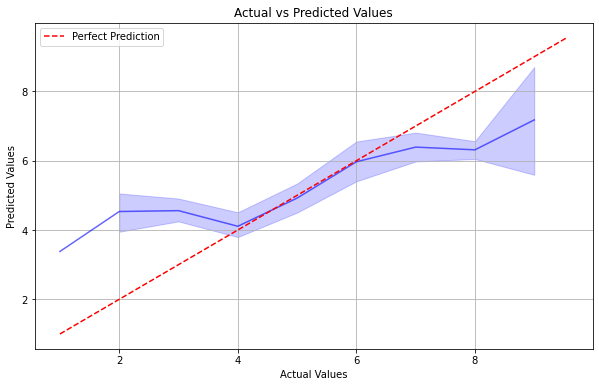

In [142]:
print('XGBoost Model')
model = train_xgboost(X_train, y_train)
evalute_model(model, X_test, y_test)

### Summary
#### The MAE score for XGBoost (1.29 bookings) is better compared to Linear Regression and Random Forest.
